In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('gerrymander.csv')

print(data.head())

data['clinton16'] = pd.to_numeric(data['clinton16'], errors='coerce')
data['trump16'] = pd.to_numeric(data['trump16'], errors='coerce')
data['dem16'] = pd.to_numeric(data['dem16'], errors='coerce')
data['dem18'] = pd.to_numeric(data['dem18'], errors='coerce')

data.fillna(0, inplace=True)

  district last_name first_name party16  clinton16  trump16  dem16 state  \
0    AK-AL     Young        Don       R       37.6     52.8      0    AK   
1    AL-01     Byrne    Bradley       R       34.1     63.5      0    AL   
2    AL-02      Roby     Martha       R       33.0     64.9      0    AL   
3    AL-03    Rogers    Mike D.       R       32.3     65.3      0    AL   
4    AL-04  Aderholt        Rob       R       17.4     80.4      0    AL   

  party18  dem18  flip18 gerry  
0       R      0       0   mid  
1       R      0       0  high  
2       R      0       0  high  
3       R      0       0  high  
4       R      0       0  high  


In [ ]:
data['margin16'] = data['clinton16'] - data['trump16']
data['margin18'] = data['dem18'] - (100 - data['dem18'])

# Gerrymandering heuristic: Ratio of votes to party representation
data['vote_to_seat_ratio'] = data['dem18'] / data['party18'].map({'D': 1, 'R': 0})

print(data[['district', 'margin16', 'margin18', 'vote_to_seat_ratio']].head())

  district  margin16  margin18  vote_to_seat_ratio
0    AK-AL     -15.2      -100                 NaN
1    AL-01     -29.4      -100                 NaN
2    AL-02     -31.9      -100                 NaN
3    AL-03     -33.0      -100                 NaN
4    AL-04     -63.0      -100                 NaN


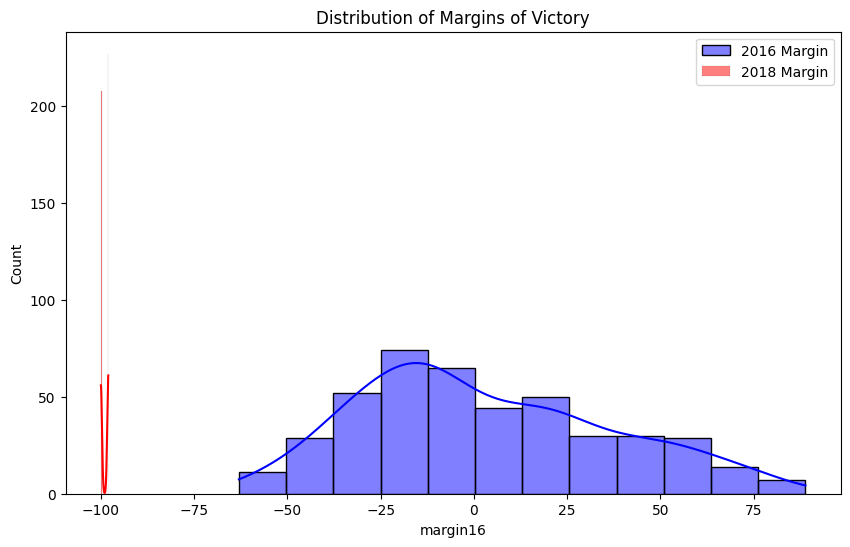

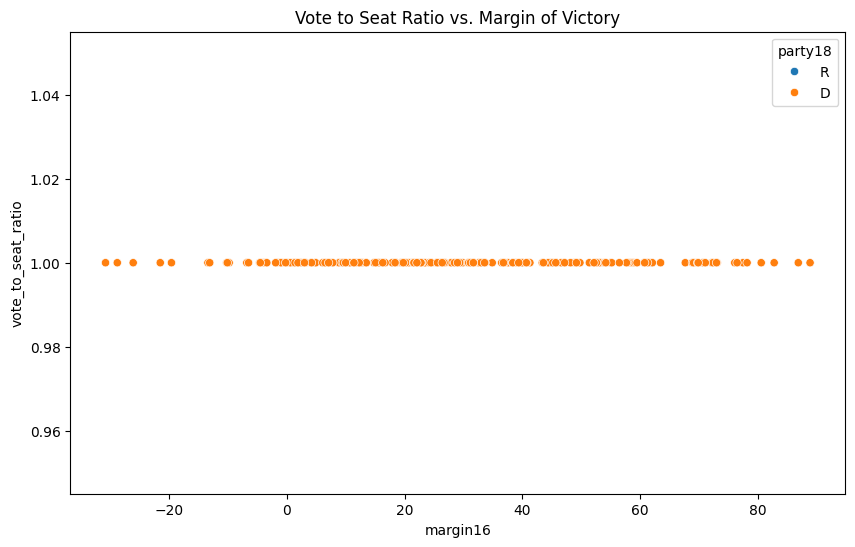

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['margin16'], kde=True, color='blue', label='2016 Margin')
sns.histplot(data['margin18'], kde=True, color='red', label='2018 Margin')
plt.title('Distribution of Margins of Victory')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='margin16', y='vote_to_seat_ratio', hue='party18', data=data)
plt.title('Vote to Seat Ratio vs. Margin of Victory')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = data[['margin16', 'margin18', 'vote_to_seat_ratio']]
y = data['gerry']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 3  6 19]
 [ 3  3 12]
 [20 10 55]]
              precision    recall  f1-score   support

        high       0.12      0.11      0.11        28
         low       0.16      0.17      0.16        18
         mid       0.64      0.65      0.64        85

    accuracy                           0.47       131
   macro avg       0.30      0.31      0.31       131
weighted avg       0.46      0.47      0.46       131



    district  margin16  margin18  vote_to_seat_ratio  gerrymandering_index
0      AK-AL     -15.2      -100                 0.0                   0.0
1      AL-01     -29.4      -100                 0.0                   0.0
2      AL-02     -31.9      -100                 0.0                   0.0
3      AL-03     -33.0      -100                 0.0                   0.0
4      AL-04     -63.0      -100                 0.0                   0.0
..       ...       ...       ...                 ...                   ...
430    WI-08     -17.6      -100                 0.0                   0.0
431    WV-01     -41.6      -100                 0.0                   0.0
432    WV-02     -36.4      -100                 0.0                   0.0
433    WV-03     -49.2      -100                 0.0                   0.0
434    WY-AL     -47.6      -100                 0.0                   0.0

[435 rows x 5 columns]


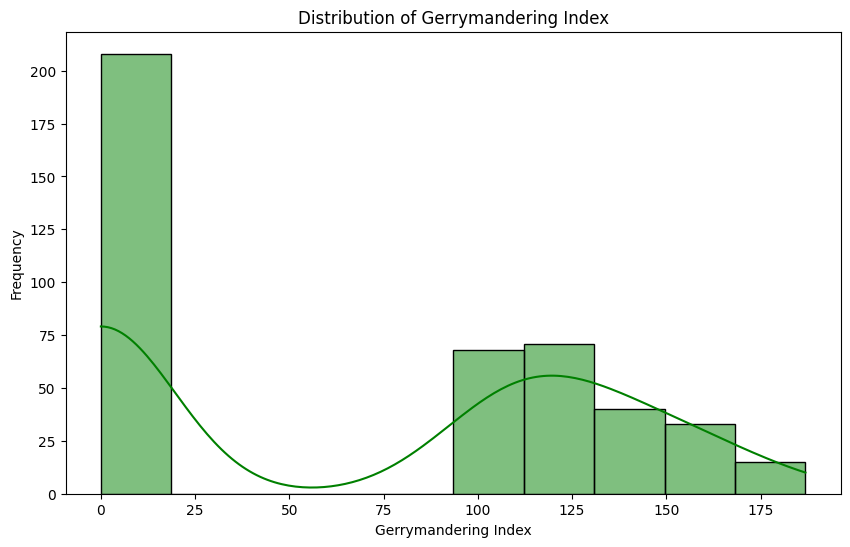

In [ ]:
def calculate_gerrymandering_index(data):
    data['vote_to_seat_ratio'].fillna(0, inplace=True)

    # Calculate the gerrymandering index
    data['gerrymandering_index'] = (data['margin16'].abs() + data['margin18'].abs()) * data['vote_to_seat_ratio']

    return data

data = calculate_gerrymandering_index(data)

print(data[['district', 'margin16', 'margin18', 'vote_to_seat_ratio', 'gerrymandering_index']])

plt.figure(figsize=(10, 6))
sns.histplot(data['gerrymandering_index'], kde=True, color='green')
plt.title('Distribution of Gerrymandering Index')
plt.xlabel('Gerrymandering Index')
plt.ylabel('Frequency')
plt.show()


In [ ]:
new_districts = pd.DataFrame({
    'margin16': [10, -5, 15],
    'margin18': [8, -3, 12],
    'vote_to_seat_ratio': [0.9, 1.1, 0.85]
})

predictions = model.predict(new_districts)
print("Predictions for new districts:", predictions)


Predictions for new districts: ['low' 'mid' 'high']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_prob = model.predict_proba(X_test)

auc_roc = roc_auc_score(y_test_binarized, y_prob, average='macro', multi_class='ovr')

print(f"AUC-ROC Score: {auc_roc * 100:.2f}%")

AUC-ROC Score: 45.45%


In [ ]:
import pickle
def save_model(model, filename='gerry.pkl'):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
save_model(model)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

Accuracy: 46.56%
Precision: 30.43%
Recall: 30.70%
F1-Score: 30.55%


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Improved Accuracy: {accuracy * 100:.2f}%")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'class_weight': None}
Improved Accuracy: 53.44%
[[ 2  5 21]
 [ 3  2 13]
 [15  4 66]]
              precision    recall  f1-score   support

        high       0.10      0.07      0.08        28
         low       0.18      0.11      0.14        18
         mid       0.66      0.78      0.71        85

    accuracy                           0.53       131
   macro avg       0.31      0.32      0.31       131
weighted avg       0.47      0.53      0.50       131



In [ ]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Define the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models,
                                  final_estimator=RandomForestClassifier(random_state=42),
                                  n_jobs=-1, cv=5, verbose=2)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Predict using the stacking classifier
y_pred_stack = stacking_clf.predict(X_test)

# Evaluate the accuracy
accuracy_stack = accuracy_score(y_test, y_pred_stack)
print(f"Stacking Classifier Accuracy: {accuracy_stack * 100:.2f}%")

# Display confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))


Stacking Classifier Accuracy: 58.78%
[[ 0  0 28]
 [ 2  0 16]
 [ 4  4 77]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        28
         low       0.00      0.00      0.00        18
         mid       0.64      0.91      0.75        85

    accuracy                           0.59       131
   macro avg       0.21      0.30      0.25       131
weighted avg       0.41      0.59      0.49       131



In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Create a new DataFrame with polynomial features
feature_names = poly.get_feature_names_out()
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# Include the new features in the dataset
X_train_poly, X_test_poly = train_test_split(X_poly_df, test_size=0.3, random_state=42)

# Define and train the stacking classifier with new features
stacking_clf.fit(X_train_poly, y_train)

# Predict and evaluate with new features
y_pred_poly = stacking_clf.predict(X_test_poly)
accuracy_poly = accuracy_score(y_test, y_pred_poly)
print(f"Stacking Classifier Accuracy with Polynomial Features: {accuracy_poly * 100:.2f}%")

print(confusion_matrix(y_test, y_pred_poly))
print(classification_report(y_test, y_pred_poly))


Stacking Classifier Accuracy with Polynomial Features: 61.83%
[[ 3  0 25]
 [ 1  2 15]
 [ 9  0 76]]
              precision    recall  f1-score   support

        high       0.23      0.11      0.15        28
         low       1.00      0.11      0.20        18
         mid       0.66      0.89      0.76        85

    accuracy                           0.62       131
   macro avg       0.63      0.37      0.37       131
weighted avg       0.61      0.62      0.55       131

